In [1]:
import numpy as np
import pandas as pd
from tools.get_data.get_data_h5 import *
from pandasgui import show
import talib as ta
import datetime
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
import numpy as np
import pandas as pd
import os
import plotly.express as px
from IPython.display import display


### 1. 获取factor数据

In [2]:
import factors  as fc
def cal_original_factors(symbol, freq = "minbar", type = "future", source_dir="Y:/DataBase_RQ_files/"):
    data = get_data(symbol = symbol, freq = freq, type=type, source_dir=source_dir)
    data["sma_diff_5"] = fc.sma_diff(data, 5)
    data["sma_diff_20000"] = fc.sma_diff(data, 20000)
    data["ema_diff_300"] = fc.ema_diff(data, 300)
    data["ema_diff_1000"] = fc.ema_diff(data, 1000)
    data["sma_of_sma_5_10"] = fc.sma_of_sma(data, 5, 10)
    data["ema_of_ema_10_30"] = fc.ema_of_ema(data, 10, 30)
    data["sma_diff_sma_5_100"] = fc.sma_diff_sma(data, 5, 100)
    data["high_60"] = fc.high(data, 60)
    data["low_60"] = fc.low(data, 60)
    data["high_60"] = fc.high(data, 60)
    data["low_60"] = fc.low(data, 60)
    data["wl_60"] = fc.wl(data, 60)
    data["wl_60"] = fc.wl(data, 60)
    data["macd_dif"], data["macd_dea"], data["macd_hist"], data["macd_signal"] = fc.MACD(
        data, fast=10, slow=60, mid=15)
    data["slope"] = fc.slope(data, 60)
    data["rsi_60"] = fc.rsi(data, 60)
    data["sar"] = fc.sar(data)
    data["rwr_60"] = fc.rwr(data, 60)
    data["rsi_100"] = fc.rsi(data, 100)
    data["rwr_100"] = fc.rwr(data, 100)
    data["aroon_up"], data["aroon_down"], data["aroon"] = fc.aroon(data, 60)
    data["tendstrength"] = fc.tendstrength(data, 120)
    data["boll"] = fc.boll(data, 200)
    data["don"] = fc.don(data, 100)
    data["sf01"] = fc.sf01(data, 60)
    data["cor_vol"] = fc.cor_vol(data, 200)
    data["cor_oi"] = fc.cor_oi(data, 1000)    
    data.to_parquet(f".//data//{symbol}_orignal_factors.parquet")
    print(f"{symbol} done")
# cal_original_factors("rb99")
# cal_original_factors("ic99")


In [3]:
from importlib import reload
import FactorAnalyzer as fa
reload(fa)

<module 'FactorAnalyzer' from 'E:\\Work\\5 Research\\factor_analysis\\FactorAnalyzer.py'>

In [ ]:
original_factors = ["ic99_orignal_factors.parquet","rb99_orignal_factors.parquet"]
run = True
if run:
    for symbol in original_factors:
        data = pd.read_parquet(".//data//"+symbol)[:100000]
        data = data.dropna()
        data.set_index("datetime", inplace=True,drop=True)    
        data = data.drop(["symbol","trading_date"],axis=1)
        prices = data["close"]
        fa_test = fa.FactorRanker(data,prices)
        fa_test.cal_factors_and_rtns(symbol[:4],bins=20,sample_size=2000,save=True)
        # fa_test.cal_factors_and_rtns(symbol[:4],bins=20,sample_size=5000,save=True)
        # fa_test.cal_factors_and_rtns(symbol[:4],bins=30,sample_size=10000,save=True)
        # fa_test.cal_factors_and_rtns(symbol[:4],bins=30,sample_size=20000,save=True)
        # fa_test.cal_factors_and_rtns(symbol[:4],bins=30,sample_size=30000,save=True)


Empty DataFrame0%
Columns: [open, high, low, close, volume, total_turnover, open_interest, sma_diff_5, sma_diff_20000, ema_diff_300, ema_diff_1000, sma_of_sma_5_10, ema_of_ema_10_30, sma_diff_sma_5_100, high_60, low_60, wl_60, macd_dif, macd_dea, macd_hist, macd_signal, slope, rsi_60, sar, rwr_60, rsi_100, rwr_100, aroon_up, aroon_down, aroon, tendstrength, boll, don, sf01, cor_vol, cor_oi, open_interest_rank, high_60_rank, ema_diff_1000_rank, sma_diff_sma_5_100_rank, sma_diff_20000_rank, volume_rank, ema_diff_300_rank, low_rank, sma_diff_5_rank, ema_of_ema_10_30_rank, close_rank, sma_of_sma_5_10_rank, low_60_rank, total_turnover_rank, high_rank, open_rank, macd_dea_rank, macd_dif_rank, aroon_down_rank, macd_signal_rank, aroon_up_rank, slope_rank, macd_hist_rank, wl_60_rank, tendstrength_rank, rwr_60_rank, aroon_rank, rsi_60_rank, sar_rank, rwr_100_rank, rsi_100_rank, boll_rank, cor_oi_rank, cor_vol_rank, don_rank, sf01_rank]
Index: []

[0 rows x 72 columns]                      future

In [5]:
pd.read_parquet(".//data//ic99_2000_20_rank_returns_df.parquet")

,open,high,low,close,volume,total_turnover,open_interest,sma_diff_5,sma_diff_20000,ema_diff_300,...,future_170_rtn(%),future_175_rtn(%),future_180_rtn(%),future_185_rtn(%),future_190_rtn(%),future_195_rtn(%),future_200_rtn(%),future_300_rtn(%),future_400_rtn(%),future_500_rtn(%)


In [17]:
factors = pd.read_parquet(".//data//ic99_20000_30_rank_df.parquet")
rtn = pd.read_parquet(".//data//ic99_20000_30_returns_df.parquet")
show(factors.head(20))
show(rtn.head(20))

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [22]:
rfa = fa.RankFactorAnalyzer(factors,rtn)

In [23]:
rfa.cal_rank_results()

future_1_rtn(%)_mean  future_2_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.000352             -0.000733   
                         1.0              -0.000147             -0.000131   
                         2.0              -0.000071             -0.000070   
                         3.0               0.000581              0.000847   
                         4.0              -0.000728             -0.000980   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.001660              0.004163   
                         15.0              0.002983              0.003982   
                         16.0              0.001203              0.003059   
                         17.0              0.010075              0.019212   
                         18.0             -0.037767             -0.091912   

                               future_3_rtn(%)_mean  future_4_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.001103             -0.001510   
                         1.0              -0.000142             -0.000115   
                         2.0              -0.000010              0.000570   
                         3.0               0.001000              0.000554   
                         4.0              -0.001149             -0.001136   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.006331              0.006916   
                         15.0              0.005617              0.007327   
                         16.0              0.002733              0.003704   
                         17.0              0.028199              0.038328   
                         18.0             -0.097088             -0.088602   

                               future_5_rtn(%)_mean  future_6_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.001891             -0.002207   
                         1.0              -0.000060             -0.000113   
                         2.0               0.001105              0.001543   
                         3.0               0.000328              0.000164   
                         4.0              -0.001095             -0.001443   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.007485              0.008496   
                         15.0              0.007399              0.007425   
                         16.0              0.006014              0.006814   
                         17.0              0.037185              0.033261   
                         18.0             -0.072365             -0.098411   

                               future_7_rtn(%)_mean  future_8_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.002489             -0.002855   
                         1.0              -0.000112              0.000091   
                         2.0               0.002078              0.002454   
                         3.0              -0.000121             -0.000216   
                         4.0              -0.001853             -0.002118   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.009305              0.009458   
                         15.0              0.007657              0.008801   
                         16.0              0.007857              0.009029   
                         17.0              0.037362              0.044298   
                         18.0             -0.115681             -0.114752   

                       

future_1_rtn(%)_mean  future_2_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.000352             -0.000733   
                         1.0              -0.000147             -0.000131   
                         2.0              -0.000071             -0.000070   
                         3.0               0.000581              0.000847   
                         4.0              -0.000728             -0.000980   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.001660              0.004163   
                         15.0              0.002983              0.003982   
                         16.0              0.001203              0.003059   
                         17.0              0.010075              0.019212   
                         18.0             -0.037767             -0.091912   

                               future_3_rtn(%)_mean  future_4_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.001103             -0.001510   
                         1.0              -0.000142             -0.000115   
                         2.0              -0.000010              0.000570   
                         3.0               0.001000              0.000554   
                         4.0              -0.001149             -0.001136   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.006331              0.006916   
                         15.0              0.005617              0.007327   
                         16.0              0.002733              0.003704   
                         17.0              0.028199              0.038328   
                         18.0             -0.097088             -0.088602   

                               future_5_rtn(%)_mean  future_6_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.001891             -0.002207   
                         1.0              -0.000060             -0.000113   
                         2.0               0.001105              0.001543   
                         3.0               0.000328              0.000164   
                         4.0              -0.001095             -0.001443   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.007485              0.008496   
                         15.0              0.007399              0.007425   
                         16.0              0.006014              0.006814   
                         17.0              0.037185              0.033261   
                         18.0             -0.072365             -0.098411   

                               future_7_rtn(%)_mean  future_8_rtn(%)_mean  \
factor                   rank                                               
open_interest_rank       0.0              -0.002489             -0.002855   
                         1.0              -0.000112              0.000091   
                         2.0               0.002078              0.002454   
                         3.0              -0.000121             -0.000216   
                         4.0              -0.001853             -0.002118   
...                                             ...                   ...   
sf01_rank_rank_rank_rank 14.0              0.009305              0.009458   
                         15.0              0.007657              0.008801   
                         16.0              0.007857              0.009029   
                         17.0              0.037362              0.044298   
                         18.0             -0.115681             -0.114752   

                       

In [24]:
rfa.factors_select(window=1)

long factor:


mean_rtn   win_rate  \
factor                            rank return                                   
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)  0.835767  65.418118   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)  0.605355  60.397403   
high_rank                         3.0  future_500_rtn(%)  0.589512  62.281276   
high_rank_rank                    22.0 future_500_rtn(%)  0.585943  60.317906   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)  0.582874  71.636364   
...                                                            ...        ...   
sma_diff_20000_rank_rank          26.0 future_150_rtn(%) -0.858688  35.664873   
                                       future_155_rtn(%) -0.887516  36.664105   
                                       future_160_rtn(%) -0.918617  36.049193   
                                       future_165_rtn(%) -0.945247  36.126057   
                                       future_170_rtn(%) -0.978945  35.972329   

                                                          count  \
factor                            rank return                     
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)   1148   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)   5083   
high_rank                         3.0  future_500_rtn(%)  12230   
high_rank_rank                    22.0 future_500_rtn(%)  10695   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)   1375   
...                                                         ...   
sma_diff_20000_rank_rank          26.0 future_150_rtn(%)   1301   
                                       future_155_rtn(%)   1301   
                                       future_160_rtn(%)   1301   
                                       future_165_rtn(%)   1301   
                                       future_170_rtn(%)   1301   

                                                          effective_period  
factor                            rank return                               
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)              36.0  
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)             125.0  
high_rank                         3.0  future_500_rtn(%)              56.0  
high_rank_rank                    22.0 future_500_rtn(%)              88.0  
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)               6.0  
...                                                                    ...  
sma_diff_20000_rank_rank          26.0 future_150_rtn(%)               NaN  
                                       future_155_rtn(%)               NaN  
                                       future_160_rtn(%)               NaN  
                                       future_165_rtn(%)               NaN  
                                       future_170_rtn(%)               NaN  

[224039 rows x 4 columns]

short factor:


mean_rtn   win_rate  \
factor                            rank return                                   
sma_diff_20000_rank_rank          26.0 future_170_rtn(%)  0.978945  64.027671   
                                       future_165_rtn(%)  0.945247  63.873943   
                                       future_160_rtn(%)  0.918617  63.950807   
                                       future_155_rtn(%)  0.887516  63.335895   
                                       future_150_rtn(%)  0.858688  64.335127   
...                                                            ...        ...   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%) -0.582874  28.363636   
high_rank_rank                    22.0 future_500_rtn(%) -0.585943  39.682094   
high_rank                         3.0  future_500_rtn(%) -0.589512  37.718724   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%) -0.605355  39.602597   
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%) -0.835767  34.581882   

                                                          count  \
factor                            rank return                     
sma_diff_20000_rank_rank          26.0 future_170_rtn(%)   1301   
                                       future_165_rtn(%)   1301   
                                       future_160_rtn(%)   1301   
                                       future_155_rtn(%)   1301   
                                       future_150_rtn(%)   1301   
...                                                         ...   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)   1375   
high_rank_rank                    22.0 future_500_rtn(%)  10695   
high_rank                         3.0  future_500_rtn(%)  12230   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)   5083   
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)   1148   

                                                          effective_period  
factor                            rank return                               
sma_diff_20000_rank_rank          26.0 future_170_rtn(%)              95.0  
                                       future_165_rtn(%)              94.0  
                                       future_160_rtn(%)              92.0  
                                       future_155_rtn(%)              92.0  
                                       future_150_rtn(%)              91.0  
...                                                                    ...  
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)               6.0  
high_rank_rank                    22.0 future_500_rtn(%)              88.0  
high_rank                         3.0  future_500_rtn(%)              56.0  
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)             125.0  
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)              36.0  

[224039 rows x 4 columns]

(                                                          mean_rtn   win_rate  \
 factor                            rank return                                   
 open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)  0.835767  65.418118   
 sma_diff_20000_rank_rank          22.0 future_500_rtn(%)  0.605355  60.397403   
 high_rank                         3.0  future_500_rtn(%)  0.589512  62.281276   
 high_rank_rank                    22.0 future_500_rtn(%)  0.585943  60.317906   
 ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)  0.582874  71.636364   
 ...                                                            ...        ...   
 sma_diff_20000_rank_rank          26.0 future_150_rtn(%) -0.858688  35.664873   
                                        future_155_rtn(%) -0.887516  36.664105   
                                        future_160_rtn(%) -0.918617  36.049193   
                                        future_165_rtn(%) -0.945247  36.126057   
                

long factor:


mean_rtn   win_rate  \
factor                            rank return                                   
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)  0.835767  65.418118   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)  0.605355  60.397403   
high_rank                         3.0  future_500_rtn(%)  0.589512  62.281276   
high_rank_rank                    22.0 future_500_rtn(%)  0.585943  60.317906   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)  0.582874  71.636364   
...                                                            ...        ...   
sma_diff_20000_rank_rank          26.0 future_150_rtn(%) -0.858688  35.664873   
                                       future_155_rtn(%) -0.887516  36.664105   
                                       future_160_rtn(%) -0.918617  36.049193   
                                       future_165_rtn(%) -0.945247  36.126057   
                                       future_170_rtn(%) -0.978945  35.972329   

                                                          count  \
factor                            rank return                     
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)   1148   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)   5083   
high_rank                         3.0  future_500_rtn(%)  12230   
high_rank_rank                    22.0 future_500_rtn(%)  10695   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)   1375   
...                                                         ...   
sma_diff_20000_rank_rank          26.0 future_150_rtn(%)   1301   
                                       future_155_rtn(%)   1301   
                                       future_160_rtn(%)   1301   
                                       future_165_rtn(%)   1301   
                                       future_170_rtn(%)   1301   

                                                          effective_period  
factor                            rank return                               
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)              36.0  
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)             125.0  
high_rank                         3.0  future_500_rtn(%)              56.0  
high_rank_rank                    22.0 future_500_rtn(%)              88.0  
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)               6.0  
...                                                                    ...  
sma_diff_20000_rank_rank          26.0 future_150_rtn(%)               NaN  
                                       future_155_rtn(%)               NaN  
                                       future_160_rtn(%)               NaN  
                                       future_165_rtn(%)               NaN  
                                       future_170_rtn(%)               NaN  

[224039 rows x 4 columns]

short factor:


mean_rtn   win_rate  \
factor                            rank return                                   
sma_diff_20000_rank_rank          26.0 future_170_rtn(%)  0.978945  64.027671   
                                       future_165_rtn(%)  0.945247  63.873943   
                                       future_160_rtn(%)  0.918617  63.950807   
                                       future_155_rtn(%)  0.887516  63.335895   
                                       future_150_rtn(%)  0.858688  64.335127   
...                                                            ...        ...   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%) -0.582874  28.363636   
high_rank_rank                    22.0 future_500_rtn(%) -0.585943  39.682094   
high_rank                         3.0  future_500_rtn(%) -0.589512  37.718724   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%) -0.605355  39.602597   
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%) -0.835767  34.581882   

                                                          count  \
factor                            rank return                     
sma_diff_20000_rank_rank          26.0 future_170_rtn(%)   1301   
                                       future_165_rtn(%)   1301   
                                       future_160_rtn(%)   1301   
                                       future_155_rtn(%)   1301   
                                       future_150_rtn(%)   1301   
...                                                         ...   
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)   1375   
high_rank_rank                    22.0 future_500_rtn(%)  10695   
high_rank                         3.0  future_500_rtn(%)  12230   
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)   5083   
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)   1148   

                                                          effective_period  
factor                            rank return                               
sma_diff_20000_rank_rank          26.0 future_170_rtn(%)              95.0  
                                       future_165_rtn(%)              94.0  
                                       future_160_rtn(%)              92.0  
                                       future_155_rtn(%)              92.0  
                                       future_150_rtn(%)              91.0  
...                                                                    ...  
ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)               6.0  
high_rank_rank                    22.0 future_500_rtn(%)              88.0  
high_rank                         3.0  future_500_rtn(%)              56.0  
sma_diff_20000_rank_rank          22.0 future_500_rtn(%)             125.0  
open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)              36.0  

[224039 rows x 4 columns]

(                                                          mean_rtn   win_rate  \
 factor                            rank return                                   
 open_interest_rank_rank_rank_rank 15.0 future_500_rtn(%)  0.835767  65.418118   
 sma_diff_20000_rank_rank          22.0 future_500_rtn(%)  0.605355  60.397403   
 high_rank                         3.0  future_500_rtn(%)  0.589512  62.281276   
 high_rank_rank                    22.0 future_500_rtn(%)  0.585943  60.317906   
 ema_diff_300_rank_rank_rank_rank  16.0 future_500_rtn(%)  0.582874  71.636364   
 ...                                                            ...        ...   
 sma_diff_20000_rank_rank          26.0 future_150_rtn(%) -0.858688  35.664873   
                                        future_155_rtn(%) -0.887516  36.664105   
                                        future_160_rtn(%) -0.918617  36.049193   
                                        future_165_rtn(%) -0.945247  36.126057   
                

画出前3个因子的图
long factor:


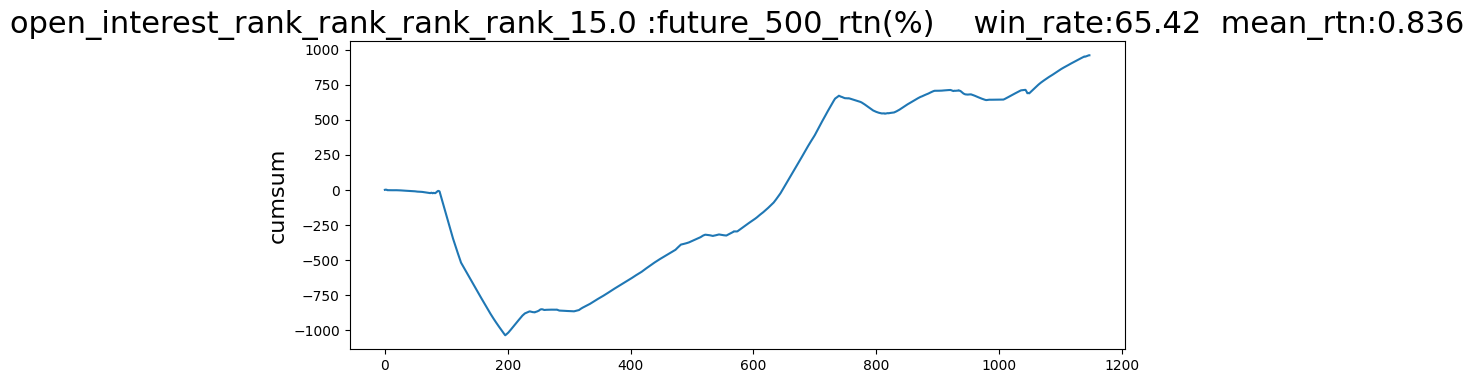

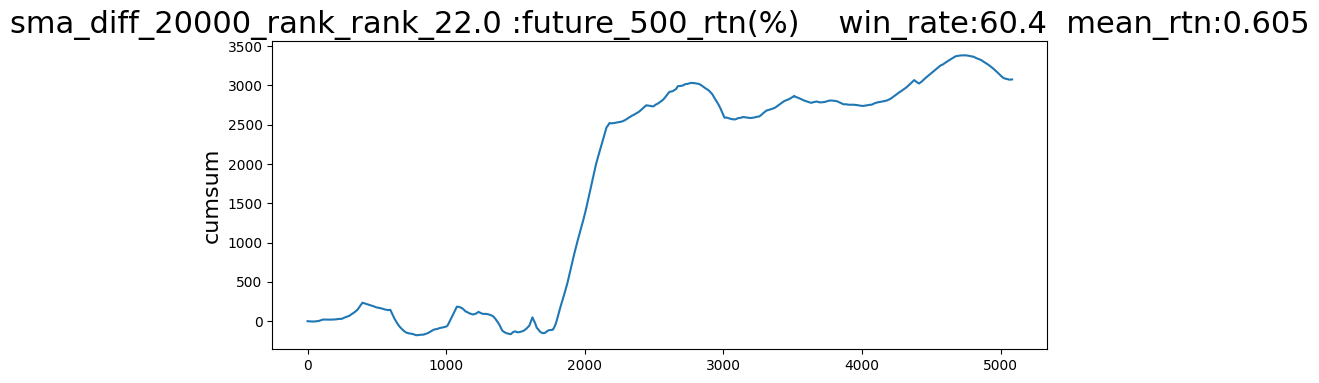

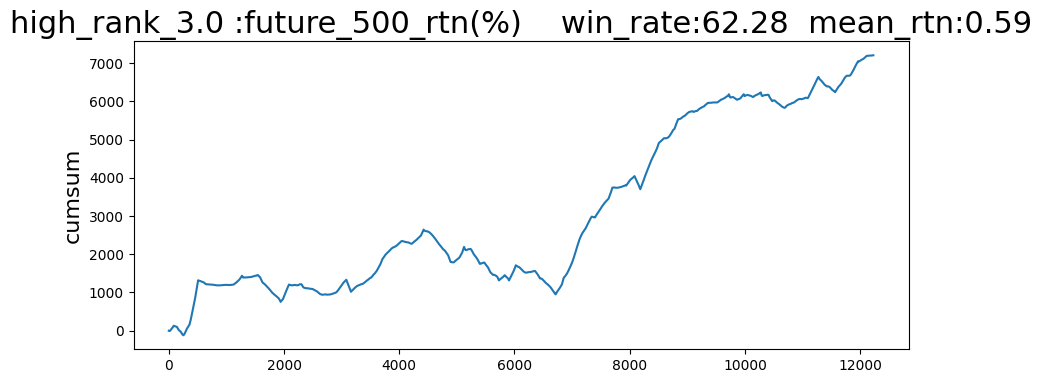

short factor:


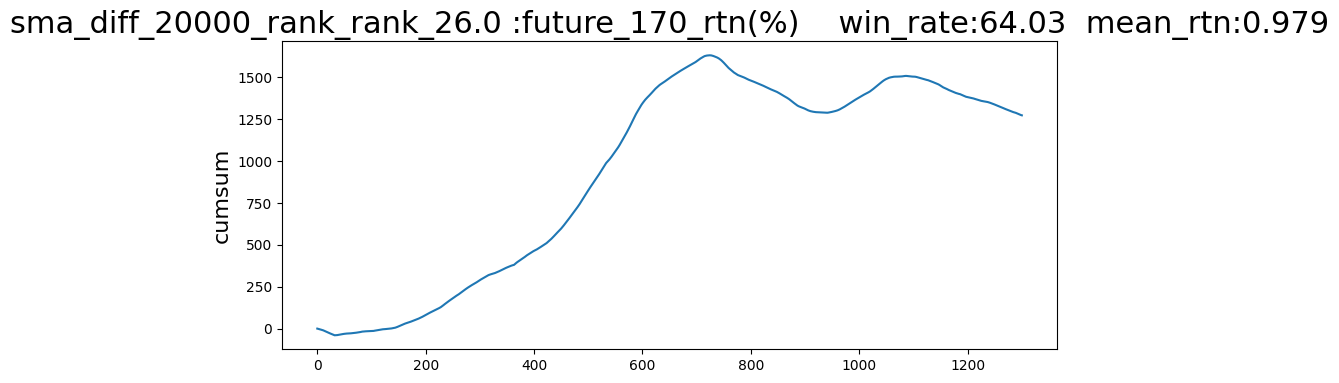

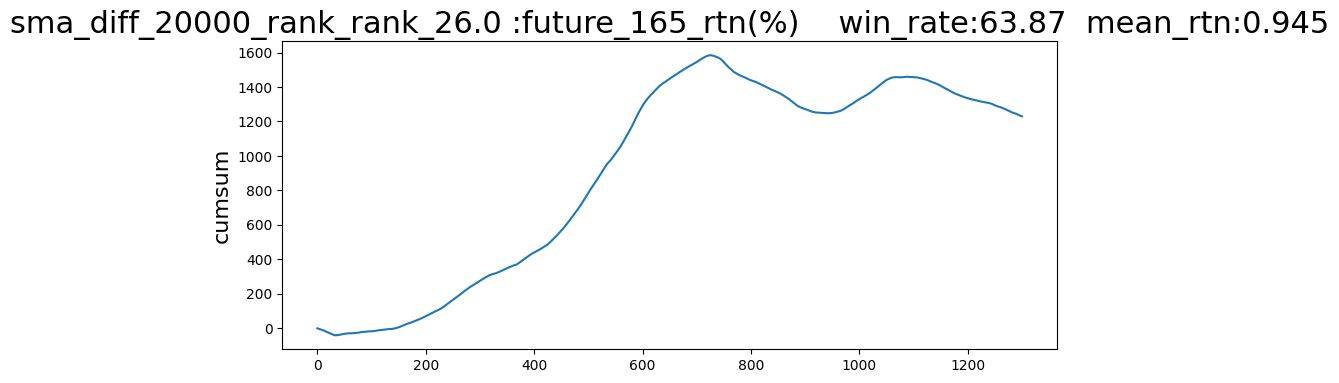

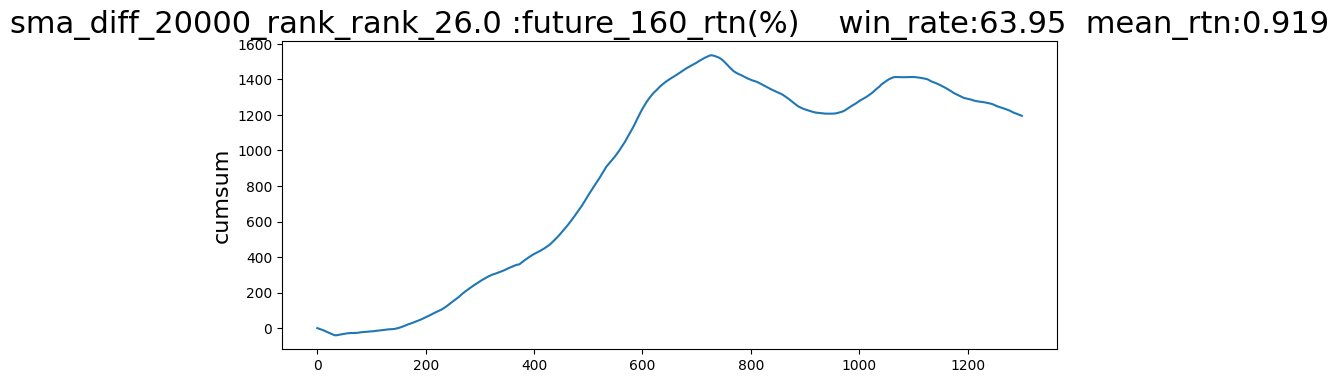

In [26]:
rfa.plots(show_dt=False)

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


class FactorAnalyzer:
    # ... 其他代码与之前相同
    def __init__(self, rank_factors, returns):
        self.rank_factors = rank_factors
        self.returns = returns
        self.data = pd.concat([rank_factors, returns], axis=1)


    def analyze_factor_effectiveness(self,ic_value:int = 0.1):
        factor_effectiveness = {}

        factor_cols=[col for col in self.data.columns if 'rtn' not in col]
        rtn_cols = [col for col in self.data.columns if 'rtn' in col]
        for factor in factor_cols:
            for rtn in rtn_cols:
                X = self.data[factor]
                X = sm.add_constant(X)
                y = self.data[rtn]
                model = sm.OLS(y, X).fit()
                factor_effectiveness[factor] = {
                    'regression_coeff': model.params[factor],
                    't_stat': model.tvalues[factor],
                    'p_value': model.pvalues[factor]
                }

        # 计算信息系数（IC）
        for factor in factor_cols:
            for rtn in rtn_cols:
                factor_values = self.data[factor]
                future_returns = self.data[rtn]
                ic = factor_values.corr(future_returns)
                factor_effectiveness[factor]['ic_{}'.format(rtn)] = ic

        self.results = pd.DataFrame(factor_effectiveness).T

        cond = (self.results >ic_value) + (self.results < -ic_value)
        ic_bigger = [(index, column, r.loc[index, column]) 
                    for column in cond.columns
                    for index in cond.index if cond.loc[index, column]]
        return self.results,ic_bigger
fa_results = FactorAnalyzer(rank_factors, rtn_df)
result,ic_bigger = fa_results.analyze_factor_effectiveness()


NameError: name 'rank_factors' is not defined

In [ ]:
result

In [ ]:
ic_bigger

In [ ]:
cond = (r>0.07) + (r<-0.1)
result = [(index, column, r.loc[index, column]) for column in cond.columns
          for index in cond.index if cond.loc[index, column]]

print(result)


In [ ]:
import pandas as pd

# 假设这是你的DataFrame
data = {'A': [1, 4, 2, 8], 'B': [5, 2, 3, 6], 'C': [3, 1, 7, 4]}

df = pd.DataFrame(data)

# 使用布尔索引找到所有大于3的数据的位置
greater_than_3 = df > 3

# 获取大于3的数据的列名、索引和值
result = [(index, column, df.loc[index, column])
          for column in greater_than_3.columns
          for index in greater_than_3.index
          if greater_than_3.loc[index, column]]

print(result)


In [ ]:
df =pd.DataFrame()
df["a"] ={"model":1,"t":3123}
df

In [ ]:
rank_fa.cumsum_plot(results_df)

In [ ]:
rank_df2 = pd.concat([rank_df, rtn_df], axis=1).dropna()
rank_df2.close_rank.max()+1

In [ ]:
rtn_df

In [ ]:
rtn_df = fa_test.cal_returns(rank_df.close)
(rtn_df[["price", "shift_1_rtn"]]-2/10000 )*100


In [ ]:
factors_1[["close","shift_1_rtn"]][2000:10000]

In [ ]:
rank_df
rank_df2 = pd.read_parquet(".//data//symbol_2000_10_rank_df.parquet")
show(rank_df2[["open", "high", "high_rank", "open_rank"]][:8000], rank_df)


### 2. 因子分析

#### 2.1 创建因子rank_df/results_df(耗时长)

In [ ]:
rank_df.equals(rank_df2[["open", "high", "high_rank", "open_rank"]][:8000])


In [ ]:
# 创建series
factors_1 = factors.set_index("datetime",  drop=True)
s = factors_1["open"]
type(s.index)

In [ ]:
if pd.core.indexes.datetimes.DatetimeIndex is pd.core.indexes.datetimes.DatetimeIndex:
    print(2)

In [ ]:
my_list = list(range(1, 31)) + list(range(30, 201, 5))
print(my_list)
list(range(31)) + list(range(30, 201, 5))


In [ ]:
rank_df2[["open", "high", "high_rank", "open_rank"]][:8000]

In [ ]:
from importlib import reload    
import factor_analysis as fa
reload(fa)
data = pd.read_parquet(".//data//factors.parquet")
data.set_index("datetime", inplace=True, drop=True)
factors_cols = []
rtn_cols = []
for col in data.columns:
    if col not in ['datetime', 'trading_date', "symbol"]:
        if "rtn" not in col and "liqka" not in col:
            factors_cols.append(col)
        else:
            rtn_cols.append(col)
factors = data[factors_cols]
rtn = data[rtn_cols]
run = 0
if run == 1:
    fal = fa.FactorAnalysis_ori()
    rank_df, results_df = fal.cal_rank_results(
    factors, rtn, save=True, sample_size=60000, bins=20)

    rank_df, results_df = fal.cal_rank_results(
        factors, rtn, save=True, sample_size=30000, bins=20)
    rank_df, results_df = fal.cal_rank_results(
        factors, rtn, save=True, sample_size=20000, bins=15)
    rank_df, results_df = fal.cal_rank_results(
        factors, rtn, save=True, sample_size=10000, bins=15)
    rank_df, results_df = fal.cal_rank_results(
        factors, rtn, save=True, sample_size=5000, bins=10)
    rank_df, results_df = fal.cal_rank_results(
        factors, rtn, save=True, sample_size=2000, bins=10)
    rank_df, results_df = fal.cal_rank_results(
        factors, rtn, save=True, sample_size=1000, bins=10)
    rank_df, results_df = fal.cal_rank_results(factors, rtn,save=True,sample_size=500,bins=10)

In [ ]:
type(factors.index) == pd.core.indexes.datetimes.DatetimeIndex

In [ ]:
# 直接读取rank_df/results_df
# print(os.listdir(".//data//"))
rank_df = pd.read_parquet(".//data//symbol_2000_10_rank_df.parquet")
results_df = pd.read_parquet(   ".//data//symbol_2000_10_results_df.parquet")
# rank_df = pd.read_parquet(".//data//symbol_30000_20_rank_df.parquet")
# results_df = pd.read_parquet(".//data//symbol_30000_20_results_df.parquet")


In [ ]:
show(rank_df.head(500),results_df.head(500))

#### 2.2 因子分析

In [ ]:
import factor_analysis as fa
from importlib import reload
reload(fa)
fal = fa.FactorAnalysis_ori()


In [ ]:
rank_df_show = rank_df.head(500)
results_df_show = results_df.head(500)
select_df = fal.factors_select(rank_df, results_df)
show(rank_df_show, results_df_show, select_df)


In [ ]:
for i in range(len(rank_df))

In [ ]:
import pandas as pd

data = {'Name': ['John', 'Anna', 'Peter', 'Linda', 'Harry'],
        'Age': [18, 19, 20, 19, 18],
        'Gender': ['M', 'F', 'M', 'F', 'M'],
        'Math Score': [85, 78, 92, 90, 87],
        'English Score': [80, 85, 88, 91, 82]}

df = pd.DataFrame(data)

selected_rows = df.query('Age==18 and `English Score`>5')
selected_rows


In [ ]:
import factor_analysis as fa
from importlib import reload
reload(fa)
fal = fa.FactorAnalysis_ori()
rank_df_e = pd.read_parquet(".//data//symbol_30000_20_rank_df.parquet")[:60000]
results_df_e = fal.cal_rank_results(factors,rtn,rank_df=rank_df_e)
results_df_e


In [ ]:
a =np.array([1,2,3,4,5,6,7,8,9,10])
# a新增一个元素11
a = np.append(a, 11)
b =np.array([1]*len(a)) -a
b

In [ ]:
on_bar函数会在每一个新的bar到来的时候被调用, 我需要记录每次在long_signal = True 或short_signal = True的时候, 分别记录下bar.close及direction的信息作为入场价格, 另外在触发close_pos > 0或者close < 0 时候的bar.close信息及direction作出出场价格, 然后根据记录的信息计算最近20次交易中的平均收益


In [ ]:
#因子分析, 画出最佳因子的累计收益图
from importlib import reload
import factor_analysis as fa
reload(fa)
fal = fa.FactorAnalysis_ori()
# seletced ={} #选择的因子
# show_up = 6
# for  i in os.listdir(".//data//"):
#     if "30000_20_results" in i:
#         _rank = i.replace("_results_df", "_rank_df")
#         _rank_df = pd.read_parquet(".//data//"+_rank)
#         sample_size,bins = i[7:-19].split("_")
#         sample_size =int(sample_size)
        # bins = int(bins)
        #重新计算因子的平均收益,胜率,有效期等信息
        # _results_df = fal.cal_rank_results(factors, rtn, rank_df = _rank_df, sample_size=sample_size, bins=bins, save=True)
        # _results_df.drop(['long_liqka_mean', 'short_liqka_mean','long_liqka_win_rate', 'short_liqka_win_rate'],axis=1,inplace=True)
        
        # # _results_df = pd.read_parquet(".//data//"+i)
        # seletced[i[7:-19]] = fal.factors_select(
        #     _results_df, win_rate=0, rtn=-3, count=None, sorted="mean_rtn")
        # display(f"seletced: { i[7:-19]}" , seletced[i[7:-19]].head())
        # fal.cumsum_plot(rank_df = _rank_df, 
        #                 results_df = _results_df,
        #                 n =3,
        #                 sorted="mean_rtn")
        
        # show_up -= 1
        # if show_up == 0:
            # break

### 3. 因子有效期分析


In [ ]:
rank_df = pd.read_parquet(".//data//symbol_30000_20_rank_df.parquet")
rank_df

In [ ]:
seletced["10000_15"]

In [ ]:

"short_liqka_mean"[:-5]


In [ ]:
_results_df

In [ ]:
rank_df[['sar_rank', 'rsi_60_rank', 'rwr_60_rank', 'rsi_100_rank','shift_155_rtn', 'shift_160_rtn', 'shift_165_rtn', 'shift_170_rtn']].head()